# Clustering Analysis

We encode the sentences with BERT and use the T-SNE algorithm to visualize them in 2 dimension.

In [1]:
import transformers
import torch
import torchvision
from mm_models import DenseNetBertMMModel, DenseNetBertMMCateModel, ImageOnlyModel, TextOnlyModel, DenseNetBertMMModelSimpleConcat, DenseNetBertMMModelConcat4

## Experiment Configurations

In [2]:
task = ['task1', 'task2'][1]
data_phase = ['train', 'dev', 'test'][2]
use_cate = True
model_path = 'W:/models/crisismmd-trained/full_task2{}.pt'.format('_cate' if use_cate else '')
model_init = DenseNetBertMMCateModel if use_cate else DenseNetBertMMModel
vis_vec = True

"""
    Create argument
"""

class Args:
    pass


opt = Args()
opt.gpu = 0
opt.batch_size = 1
opt.max_dataset_size = 2000
# opt.max_dataset_size = 100
opt.crop_size = 230
opt.load_size = 224
opt.debug = False
opt.device = 'cuda'
opt.model_to_load = model_path

Execute the sentence encoder. The model to use from the Transformers library is up to the liberty of the user.

Source: https://datascience.stackexchange.com/questions/62658/how-to-get-sentence-embedding-using-bert

## Load the dataset

In [3]:
from crisismmd_dataset import CrisisMMDataset
from args import get_args
import torch
from torch.utils.data import DataLoader

task_str = 'task1' if task == 'task1' else 'task2_merged'
dataset = CrisisMMDataset()
dataset.initialize(opt, data_phase, task=task, no_transform=True, consistent_only=False, use_cate=use_cate) # TODO: Experiment with params here!
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

[*] 2000 samples loaded.


In [4]:
labels_task1 = {
    'not_informative': 0,
    'informative': 1
}

labels_task2 = {
    'infrastructure_and_utility_damage': 0,
    'not_humanitarian': 1,
    'other_relevant_information': 2,
    'rescue_volunteering_or_donation_effort': 3,
    'vehicle_damage': 4,
    'affected_individuals': 5,
    'injured_or_dead_people': 5,
    'missing_or_found_people': 5,
}
OUTPUT_SIZE = 2 if task == 'task1' else 6

labels_mapping = labels_task1 if task == 'task1' else labels_task2


# Load the model

In [5]:
model = model_init(num_class=OUTPUT_SIZE, save_dir='.').to(opt.device)
# model = DenseNetBertMMModel(num_class=OUTPUT_SIZE, save_dir='.').to(opt.device)
model.load(opt.model_to_load)
model.return_repr = True

Using cache found in C:\Users\PaulChen/.cache\torch\hub\pytorch_vision_v0.8.0
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Retrieving representation
Feed them into the Transformers model.

In [6]:
from tqdm import tqdm
model.eval()
outputs = []
labels = []
for idx, data in tqdm(enumerate(dataloader), total=len(dataloader)):

    x = (data['image'].to(opt.device),
        {k: v.to(opt.device)
        for k, v in data['text_tokens'].items()},
        data['category_vector'].to(opt.device))

    labels.append(data['label'].item()) # TODO: Experiment with different labels here

    if vis_vec:
        outputs.append(x[2].cpu().numpy())
    else:
        repr = model(x)
        result = repr.cpu().detach().numpy()
        outputs.append(result)

    if idx > 501:
        break


 25%|██▌       | 502/2000 [00:09<00:27, 54.62it/s]


## Visualization with T-SNE

In [7]:
embedding_dim = outputs[0].shape[1]
print("Vector dimension: {}".format(embedding_dim))

Vector dimension: 152


In [8]:
import numpy as np
from tsne import tsne
from matplotlib import pyplot as plt
output_np = np.array(outputs).squeeze(1)
Y = tsne(output_np, 2, embedding_dim, 30)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 503...
Computing P-values for point 500 of 503...
Mean value of sigma: 2.888191
Iteration 10: error is 14.561484
Iteration 20: error is 14.219399
Iteration 30: error is 14.233385
Iteration 40: error is 14.217997
Iteration 50: error is 14.122571
Iteration 60: error is 14.175504
Iteration 70: error is 14.136622
Iteration 80: error is 14.121201
Iteration 90: error is 14.174287
Iteration 100: error is 14.127136
Iteration 110: error is 1.287058
Iteration 120: error is 0.880237
Iteration 130: error is 0.774435
Iteration 140: error is 0.730637
Iteration 150: error is 0.706624
Iteration 160: error is 0.689543
Iteration 170: error is 0.678360
Iteration 180: error is 0.669246
Iteration 190: error is 0.662188
Iteration 200: error is 0.656884
Iteration 210: error is 0.651896
Iteration 220: error is 0.648588
Iteration 230: error is 0.646392
Iteration 240: error is 0.644797
Iteration 250: error is 0

Saving to ./visuals/tsne-task2-test-500.png


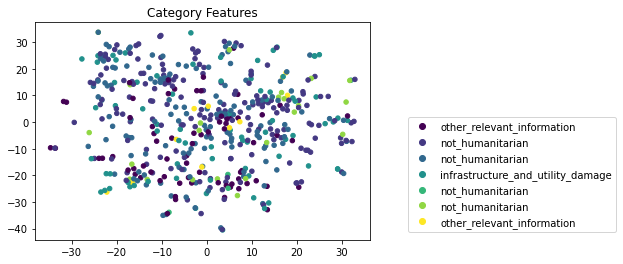

<Figure size 432x288 with 0 Axes>

In [9]:


data_points_to_plot = 500


inverse_task1 = {
     0: 'not_informative',
     1: 'informative'
}

inverse_task2 = {
    0: 'infrastructure_and_utility_damage',
    1: 'not_humanitarian',
    2: 'other_relevant_information',
    3: 'rescue_volunteering_or_donation_effort',
    4: 'vehicle_damage',
    5: 'affected_individuals',
    6: 'affected_individuals',
    7: 'affected_individuals',
}



inverse_map = inverse_task1 if task == 'task1' else inverse_task2

fig = plt.figure()
plt.title("Category Features")

label_names = [inverse_map[label] for label in labels]
scatter = plt.scatter(Y[:data_points_to_plot, 0], Y[:data_points_to_plot, 1], s=20, label=label_names, c=labels[:data_points_to_plot])

if task == 'task1':
    plt.legend(loc='lower center', handles=scatter.legend_elements()[0], labels=label_names)
elif task == 'task2':
    plt.legend(loc='right', handles=scatter.legend_elements()[0], labels=label_names, bbox_to_anchor=(1.75, 0.3))
else:
    raise NotImplemented

# file name: tsne-task-phase-model-numberofpoints
filename = './visuals/tsne-{}-{}-{}.png'.format(task, data_phase, data_points_to_plot)
print("Saving to {}".format(filename))
plt.savefig(filename)
plt.show()
plt.clf()

In [10]:
max(labels)

6